In [1]:
%matplotlib inline

#standard libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import pickle

try:
    import seaborn as sns
except:
    pass

#project libraries
from Localization.montecarlo.dualmcl import DualMCL
from Localization.sensormodel.hybrid import hGP
from Localization.sensormodel.gp import GP
from Localization.motionmodel.odometry import Odometry
from util.others import mesh

warning in stationary: failed to import cython module: falling back to numpy


In [2]:
# Visualization
sns.set_style("white")
sns.set_style("ticks")
# matplotlib 
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 22

# Load datasets

In [3]:
#Load datasets
with open('dataTrain.p', 'rb') as f:
    data = pickle.load(f)
with open('dataTest.p', 'rb') as f:
    dataTest = pickle.load(f)
with open('dataXTrue.p', 'rb') as f:
    dataXTrue = pickle.load(f)

# Load saved models or train new ones

In [9]:
load_model = True

## train models

In [4]:
if not load_model:
    #GP with no priors 
    g = GP(data)
    g.optimize()
    print g

Name                                : GP
data
  X                                 : [ 131,   2]
  Y                                 : [ 131, 173]
  Var                               : [ 131, 173]

Gaussian Process
  Name                              : GP regression
  Log-likelihood                    : 39467.1416233
  Number of Parameters              : 3
  Number of Optimization Parameters : 3
  Updates                           : True
  Parameters:
    GP_regression.           |       Value        |  Constraint  |  Prior  |  Tied to
    rbf.variance             |   0.0186238851291  |     +ve      |         |         
    rbf.lengthscale          |     12.1716229681  |     +ve      |         |         
    Gaussian_noise.variance  |  0.00104908137383  |     +ve      |         |         


In [7]:
if not load_model:
    #Hybrid GP model
    h = hGP(data,verbose=False)
    h.optimize()
    print h

Name                                : GP with pathloss
data
  X                                 : [ 131,   2]
  Y                                 : [ 131, 173]
  Var                               : [ 131, 173]

PathLoss
  Name                              : Log Function
  Log-likelihood                    : 3435.24627529
  Number of Parameters              : 692

Gaussian Process
  Name                              : GP regression
  Log-likelihood                    : 40097.0357037
  Number of Parameters              : 3
  Number of Optimization Parameters : 3
  Updates                           : True
  Parameters:
    GP_regression.           |       Value        |  Constraint  |  Prior  |  Tied to
    rbf.variance             |  0.00421197076649  |     +ve      |         |         
    rbf.lengthscale          |     7.64154798008  |     +ve      |         |         
    Gaussian_noise.variance  |  0.00104570848875  |     +ve      |         |         


## load models

In [16]:
if load_model:
    try:
        #create empty GP and hGP classes and load previously saved models
        data_empty = {'X':np.asarray([[1,1]]),'Y':np.asarray([1]),'Var':np.asarray([1])}
        g1 = GP(data_empty)
        h1 = hGP(data_empty)

        #load models
        g1.load(filepath='GPmodel1.p')  #GP model
        h1.load(filepath='hGPmodel1.p') #GP with path loss priors model
    except:
        print 'Copy models to the same folder'

# Plotting data

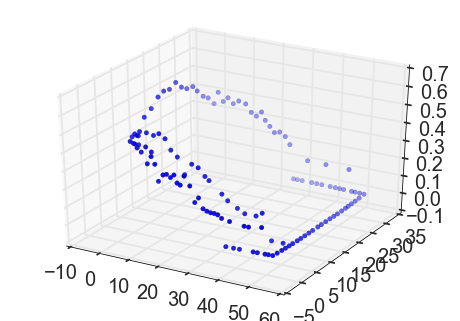

In [11]:
AP = 10
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data['X'][:,0],data['X'][:,1],data['Y'][:,AP:AP+1])
plt.show()

In [12]:
#predictions using GP and GP+pathloss
Yg,Vg = g1.predict(data['X']) #predicted_mean, predicted_variance
Yh,Vh = h1.predict(data['X']) #predicted_mean, predicted_variance

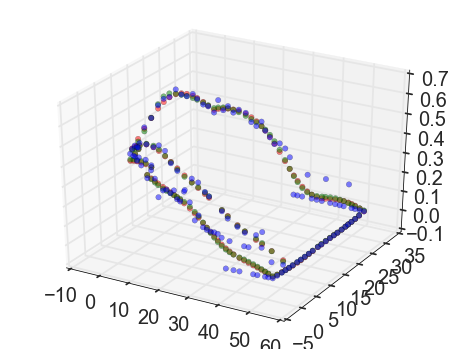

In [13]:
#predicted means
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data['X'][:,0],data['X'][:,1],data['Y'][:,AP:AP+1],s=30,alpha=0.5)
ax.scatter(data['X'][:,0],data['X'][:,1],Yg[:,AP:AP+1],c='r',s=30,alpha=0.5)
ax.scatter(data['X'][:,0],data['X'][:,1],Yh[:,AP:AP+1],c='g',s=30,alpha=0.5)
plt.show()

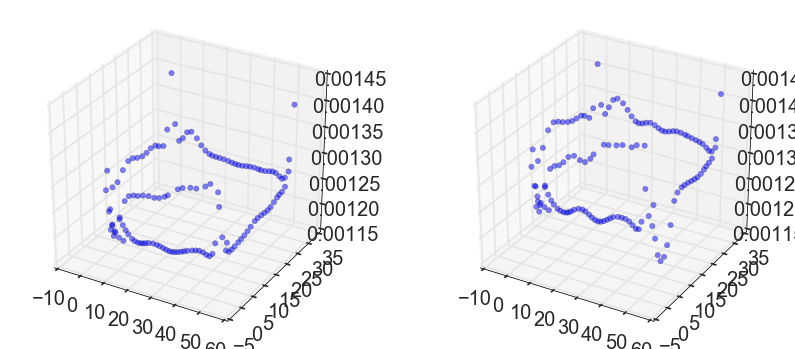

In [14]:
#predicted variances
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax1.scatter(data['X'][:,0],data['X'][:,1],Vg,s=30,alpha=0.5)
ax2.scatter(data['X'][:,0],data['X'][:,1],Vh[:,AP:AP+1],s=30,alpha=0.5)
plt.show()

# Likelihood for training dataset

In [15]:
# map limits
x_min,x_max =  -20, 70
y_min,y_max =  -20, 50
x_spn,y_spn =   45, 35

# creating XY mesh
temp_x  = np.linspace(x_min,x_max,x_spn)
temp_y  = np.linspace(y_min,y_max,y_spn)
X_new = mesh(temp_x,temp_y)

# data test
ldata = dataTest

# computing likelihoood for XY mesh
pX  = g1.jointpdf(X_new,ldata['Ytest'],ldata['Vartest'])
pX2 = h1.jointpdf(X_new,ldata['Ytest'],ldata['Vartest'])

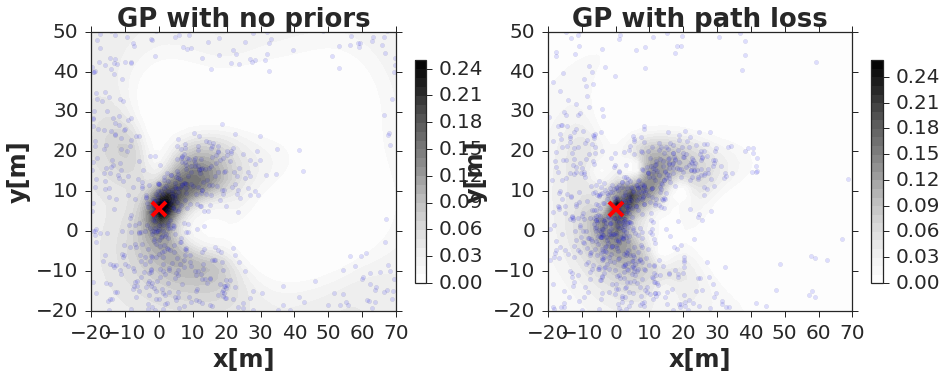

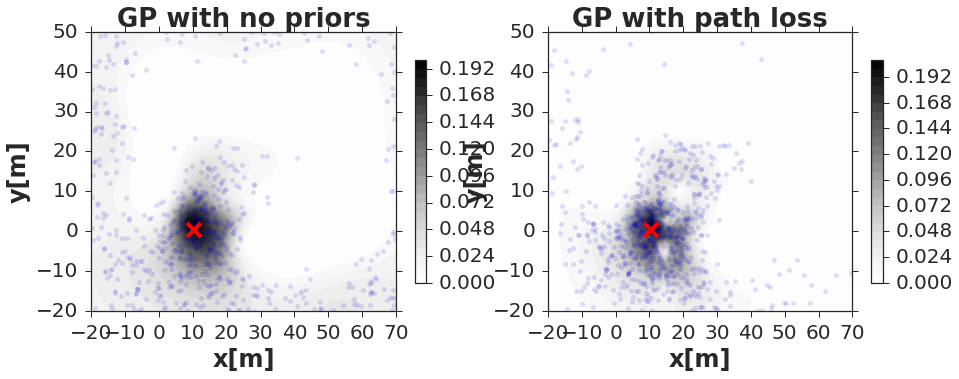

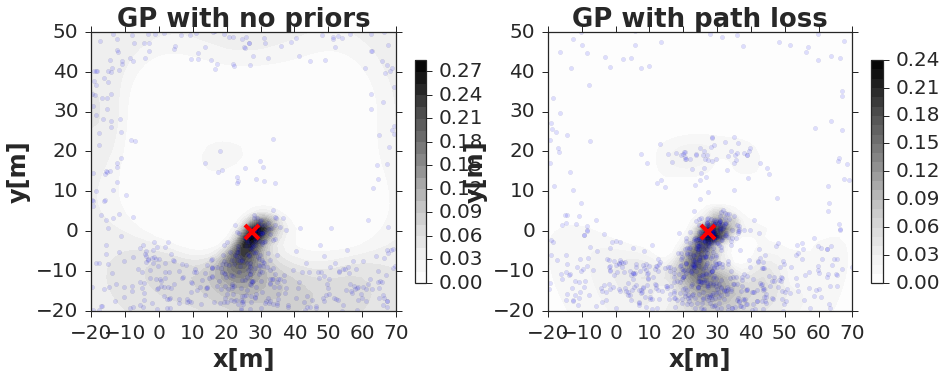

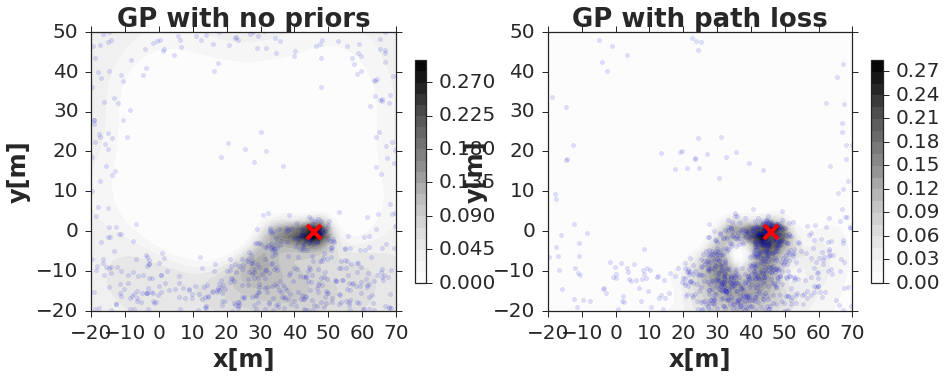

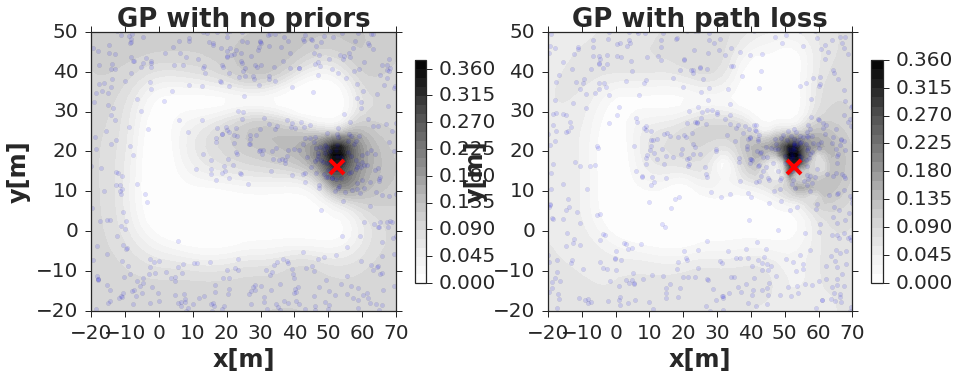

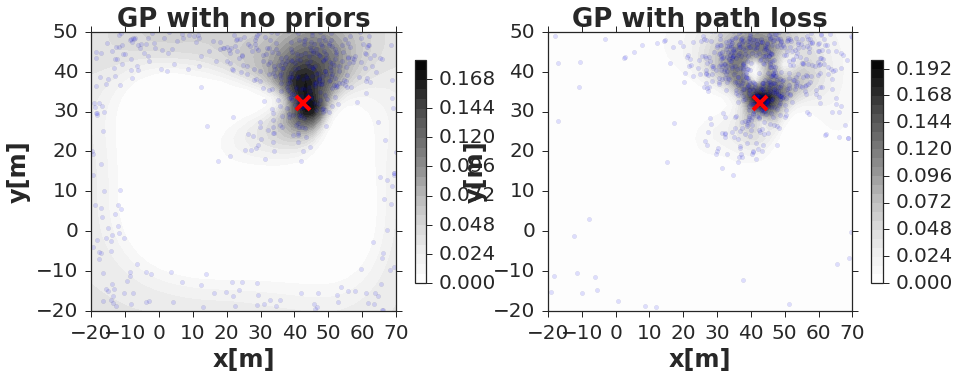

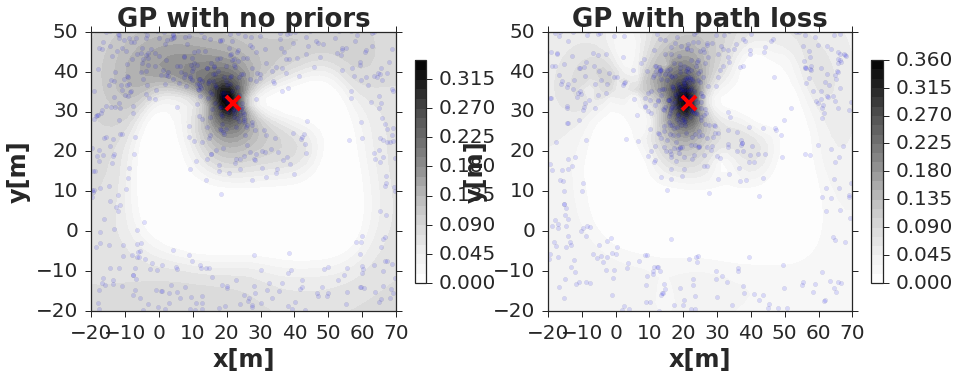

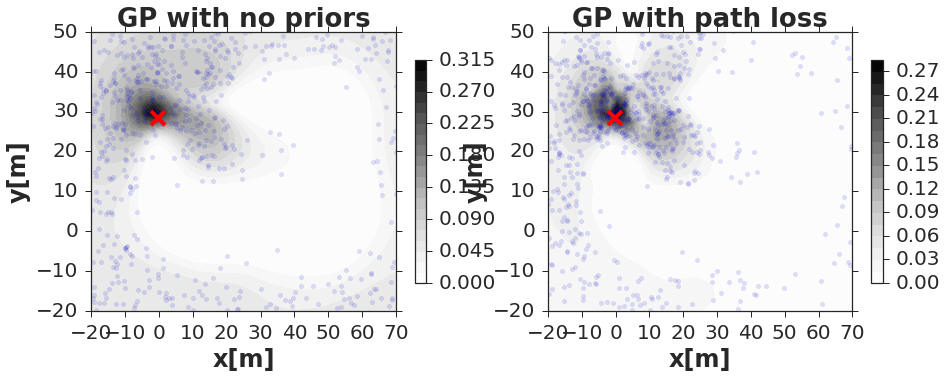

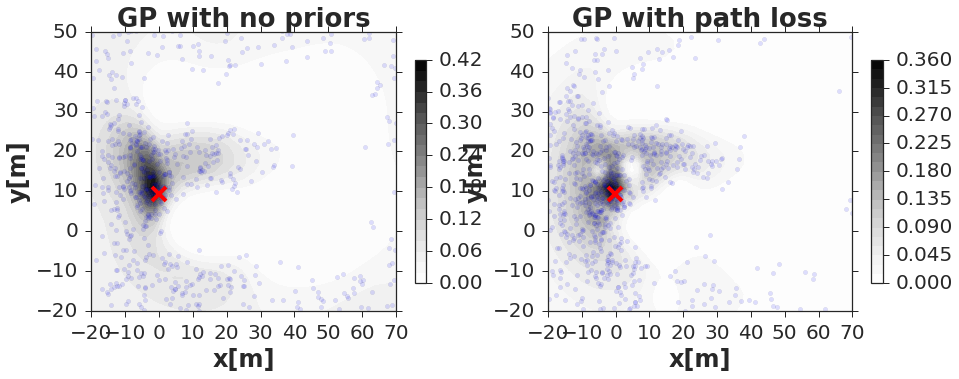

In [41]:
nsamples = 800

for i in range(0,dataTest['Xtest'].shape[0],20):
    axis_lim = (x_min,x_max,y_min,y_max)
    TestPoint = i
    fontsize=24
    
    fig = plt.figure(figsize=(15,5))
    shape = (y_spn,x_spn)
    
    #Sampling
    measurement = (ldata['Ytest'][TestPoint:TestPoint+1,:],ldata['Vartest'][TestPoint:TestPoint+1,:])
    g_sample = g1.sample(measurement,span=(-20,70),N=nsamples)
    h_sample = h1.sample(measurement,span=(-20,70),N=nsamples)
    
    #Computing maximum values
    m1 = np.max(pX[:,TestPoint])
    m2 = np.max(pX2[:,TestPoint])

    m_max = max(m1,m2)
    v = 25#np.linspace(0,m_max,25)

    ax1 = fig.add_subplot(1,2,1)
    C  = ax1.contourf(np.reshape(X_new[:,0],shape),np.reshape(X_new[:,1],shape),np.reshape(pX[:,TestPoint],shape),v)
    CB = plt.colorbar(C, shrink=0.8, extend='both')#,cmap=plt.get_cmap('Blues'))
    ax1.plot(dataXTrue[TestPoint,0],dataXTrue[TestPoint,1],'rx', markersize=14, markeredgewidth=4)
    ax1.scatter(g_sample[:,0],g_sample[:,1],c='b',alpha=.125)
    ax1.axis(axis_lim)
    
    ax1.set_title('GP with no priors',fontsize=fontsize+2,fontweight='bold')
    ax1.set_xlabel('x[m]',fontsize=fontsize,fontweight='bold')
    ax1.set_ylabel('y[m]',fontsize=fontsize,fontweight='bold') 

    ax2 = fig.add_subplot(1,2,2)
    C2  = ax2.contourf(np.reshape(X_new[:,0],shape),np.reshape(X_new[:,1],shape),np.reshape(pX2[:,TestPoint],shape),v)
    CB2 = plt.colorbar(C2, shrink=0.8, extend='both')#,cmap=plt.get_cmap('Blues'))
    ax2.plot(dataXTrue[TestPoint,0],dataXTrue[TestPoint,1],'rx', markersize=14, markeredgewidth=4)
    ax2.scatter(h_sample[:,0],h_sample[:,1],c='b',alpha=.125)
    ax2.axis(axis_lim)
    ax2.set_title('GP with path loss',fontsize=fontsize+2,fontweight='bold')
    ax2.set_xlabel('x[m]',fontsize=fontsize,fontweight='bold')
    ax2.set_ylabel('y[m]',fontsize=fontsize,fontweight='bold') 
plt.show()

# Dual MCL test

## GP without priors

In [44]:
model = g1

odometry = Odometry(N=800,distance_var=.2,angle_var=.1)
dmcl = DualMCL(model,odometry,verbose=True)
dmcl.run(dataTest['Pose'],dataTest['Ytest'],xtrue=dataXTrue,save_log=True)

g1_errors = np.asarray(dmcl.log['errors'])
g1_mean_e = np.mean(errors[25:])
g1_max_e  = np.max(errors[25:])

print 'Mean Error: ', g1_mean_e

  0    : Error: 14.7820896843      Sampling time: 0.227457046509
  1    : Error: 4.25282233616      Sampling time: 0.487274885178
  2    : Error: 2.87738255022      Sampling time: 0.496151924133
  3    : Error: 4.88059422197      Sampling time: 0.464401006699
  4    : Error: 4.5258260147      Sampling time: 0.491585969925
  5    : Error: 4.71525274266      Sampling time: 0.47336602211
  6    : Error: 4.59494144848      Sampling time: 0.506982088089
  7    : Error: 5.29177353074      Sampling time: 0.529993057251
  8    : Error: 5.23925062644      Sampling time: 0.526269197464
  9    : Error: 4.16246831427      Sampling time: 0.58224105835
  10   : Error: 4.14995763407      Sampling time: 0.623541116714
  11   : Error: 4.89121025189      Sampling time: 0.540251016617
  12   : Error: 4.73117845701      Sampling time: 0.527992963791
  13   : Error: 4.30467909222      Sampling time: 0.526561021805
  14   : Error: 3.56829384024      Sampling time: 0.520450115204
  15   : Error: 3.0857910852

## GP with path loss

In [45]:
model = h1

odometry = Odometry(N=800,distance_var=.2,angle_var=.1)
dmcl = DualMCL(model,odometry,verbose=True)
dmcl.run(dataTest['Pose'],dataTest['Ytest'],xtrue=dataXTrue,save_log=True)

h1_errors = np.asarray(dmcl.log['errors'])
h1_mean_e = np.mean(errors[25:])
h1_max_e  = np.max(errors[25:])

print 'Mean Error: ', h1_mean_e

  0    : Error: 3.13268825985      Sampling time: 0.427979946136
  1    : Error: 2.11515564131      Sampling time: 0.606163978577
  2    : Error: 2.56462955281      Sampling time: 0.792889118195
  3    : Error: 2.83123286339      Sampling time: 0.696469068527
  4    : Error: 2.08723622583      Sampling time: 0.729679107666
  5    : Error: 2.83022914202      Sampling time: 0.760777950287
  6    : Error: 4.01466790326      Sampling time: 0.731776952744
  7    : Error: 4.26280507995      Sampling time: 0.683117866516
  8    : Error: 5.32348778827      Sampling time: 0.833502054214
  9    : Error: 5.47097837648      Sampling time: 0.839460849762
  10   : Error: 5.37775069489      Sampling time: 0.715776920319
  11   : Error: 4.85154698914      Sampling time: 0.736846923828
  12   : Error: 4.62970841905      Sampling time: 0.760739088058
  13   : Error: 3.96706192207      Sampling time: 0.682646036148
  14   : Error: 3.17224182168      Sampling time: 0.704533100128
  15   : Error: 3.2891024

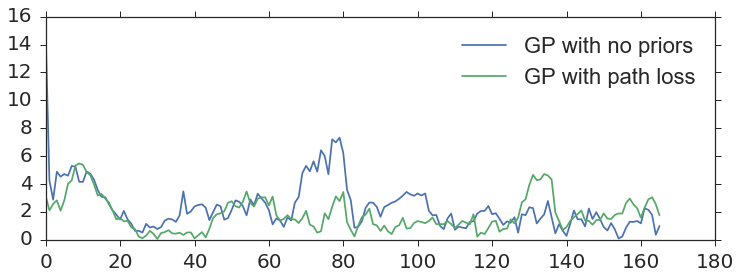

In [53]:
#ploting localization errors
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
x = np.arange(h1_errors.shape[0])
ax.plot(x,g1_errors,label='GP with no priors')
ax.plot(x,h1_errors,label='GP with path loss')
ax.legend()

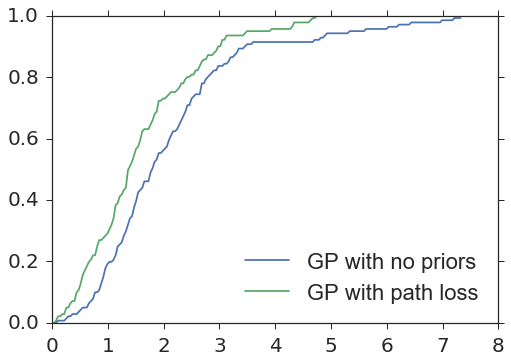

In [60]:
# plotting cumulative localization errors
x = np.linspace(0,np.max(g1_errors[25:]),200)
for m_error,label in zip((g1_errors,h1_errors),('GP with no priors','GP with path loss')):
    y = np.zeros_like(x)
    for i in range(x.shape[0]):
        y[i] = np.sum(m_error[25:]<x[i])/(m_error[25:].shape[0]*1.)
    plt.plot(x,y,label=label)
plt.legend(loc=4)